In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import PIL
from tqdm import tqdm

In [2]:
def cls_split(df, im_shape=(256, 256)):
    
    def str_to_int(x):
        ans = []
        for char in x.split(" "):
            ans.append(int(char))
        return np.array(ans)
    df["ImArr"] = df.PredictionString.map(str_to_int)
    rtn = []
    for i in tqdm(range(len(df))):
        re = np.reshape(df["ImArr"][i][:,np.newaxis],im_shape)
        cls_split = []
        for i in range(11):
            buf = np.zeros(im_shape)
            buf[re==i] = 1
            cls_split.append(buf)
        cls_split = np.array(cls_split)
        rtn.append(cls_split)
    return np.array(rtn)


In [3]:
csv_name_list = [f'output ({i}).csv' for i in range(11)]
cls_split_arr = None
for csv_name in csv_name_list:
    print(csv_name)
    df = pd.read_csv(csv_name)
    weight = (len(csv_name_list)//3 + 1)
    if cls_split_arr is None :
        cls_split_arr = cls_split(df) * weight
    else:
        cls_split_arr += cls_split(df) * weight
print("done")

output (0).csv


100%|██████████| 819/819 [00:04<00:00, 183.38it/s]


output (1).csv


100%|██████████| 819/819 [00:03<00:00, 220.54it/s]


output (2).csv


100%|██████████| 819/819 [00:03<00:00, 233.07it/s]


output (3).csv


100%|██████████| 819/819 [00:03<00:00, 232.74it/s]


output (4).csv


100%|██████████| 819/819 [00:03<00:00, 227.60it/s]


output (5).csv


100%|██████████| 819/819 [00:03<00:00, 230.15it/s]


output (6).csv


100%|██████████| 819/819 [00:03<00:00, 222.76it/s]


output (7).csv


100%|██████████| 819/819 [00:03<00:00, 233.29it/s]


output (8).csv


100%|██████████| 819/819 [00:03<00:00, 224.39it/s]


output (9).csv


100%|██████████| 819/819 [00:03<00:00, 224.23it/s]


output (10).csv


100%|██████████| 819/819 [00:03<00:00, 226.98it/s]


done


In [4]:
cls_prob = cls_split_arr/len(csv_name_list)

In [5]:
import cv2

In [18]:
def get_label_map(im_path, prediction):
    
    # Image preprocessing
    scale = 0.5
    image = cv2.imread(im_path, cv2.IMREAD_COLOR).astype(float)
    image = cv2.resize(image, dsize=None, fx=scale, fy=scale)
    image_original = image.astype(np.uint8)
    image = image.transpose(2, 0, 1)

    # Inference
    # output = model(image)
    # output = F.interpolate(
    #     output, size=image.shape[2:], mode="bilinear", align_corners=True
    # )
    # output = F.softmax(output, dim=1) ::: channel first
    # output = output.data.cpu().numpy()[0]

    # output = dense_crf(image_original, prediction)
    # labelmap = np.argmax(output, axis=0)
    # print(prediction.shape)
    labelmap = np.argmax(prediction, axis=0)
    
    return image_original, labelmap
    

In [19]:
im_dir = "/opt/ml/segmentation/input/data/"
size = 256
visualize = False
file_name_list = []
preds_array = np.empty((0, size*size), dtype=np.int64)
for idx in tqdm(range(len(df))):
    
    im_name = df.image_id[idx]
    im_path = im_dir + im_name
    prediction = cls_prob[idx]
    
    image_original, labelmap = get_label_map(im_path, prediction)
    oms = labelmap.reshape([1, size*size])
    oms = oms.astype(int)
    preds_array = np.vstack((preds_array, oms))
    file_name_list.append(im_name)

# sample_submisson.csv 열기
submission = pd.read_csv(
    './sample_submission.csv', index_col=None
)

# PredictionString 대입
for file_name, string in tqdm(zip(file_name_list, preds_array)):
    str_to_list = []
    for e in string.tolist():
        if bool(e) :
            str_to_list.append(str(e))
        else:
            str_to_list.append("0")
    
    submission = submission.append(
        {
            "image_id" : file_name, 
             "PredictionString" : ' '.join(str_to_list)
        },
        ignore_index=True
    )

# submission.csv로 저장
submission.to_csv(
    "weighted_hard_vote.csv",
    index=False
)

100%|██████████| 819/819 [01:24<00:00,  9.68it/s]
819it [00:16, 48.42it/s]


/tmp/ipykernel_33001/97667324.py:18: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot(rows, cols, 1)
/tmp/ipykernel_33001/97667324.py:30: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot(rows, cols, i + 2)


  0: Background
  8: Plastic bag


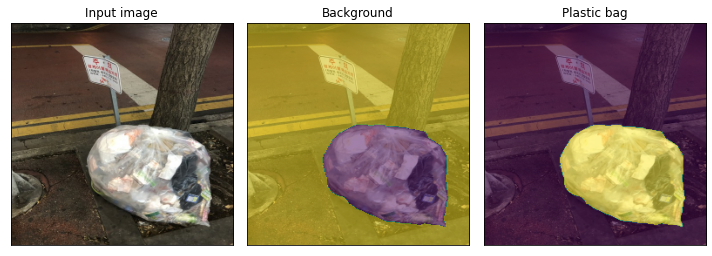

  0: Background
  1: General trash
  8: Plastic bag


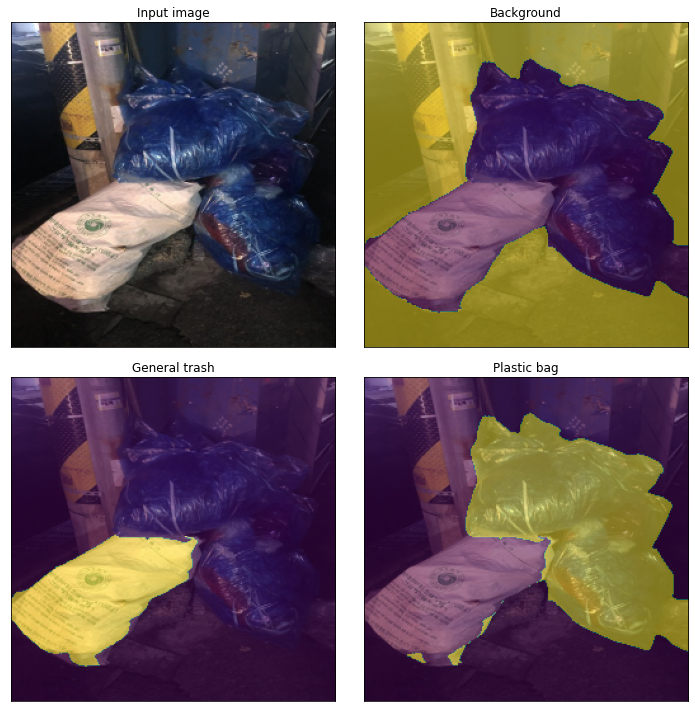

  0: Background
  1: General trash


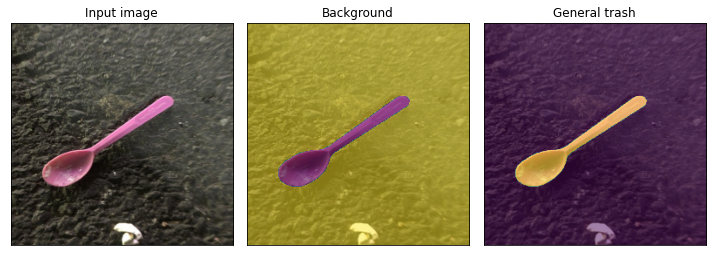

  0: Background
  2: Paper
  8: Plastic bag


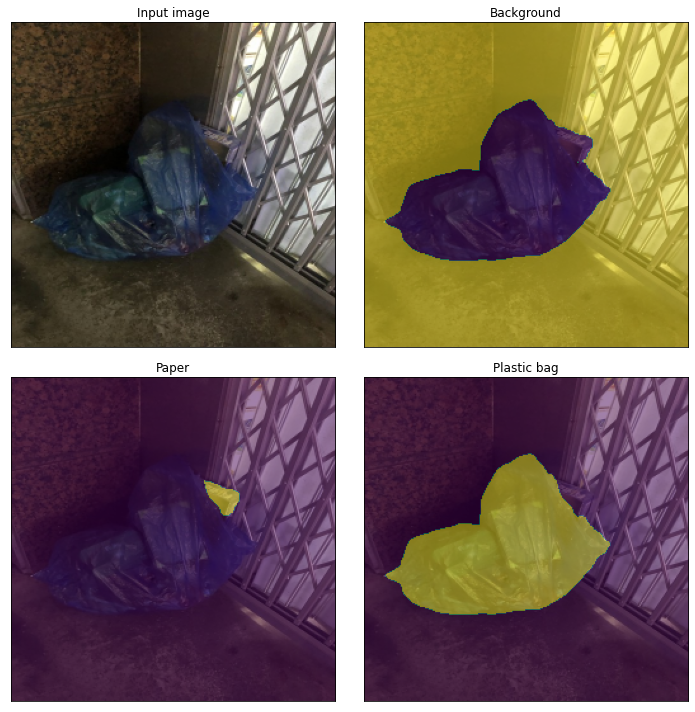

  0: Background
  1: General trash
  8: Plastic bag


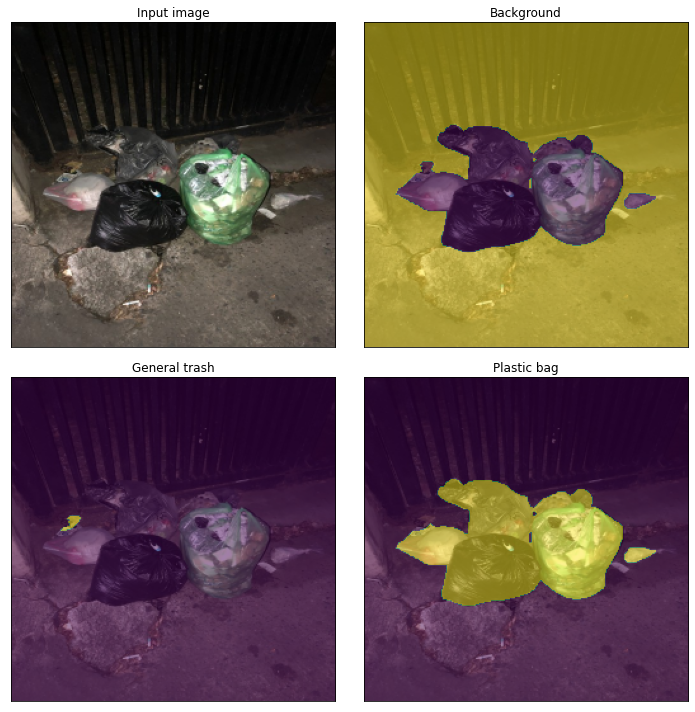

  0: Background
  8: Plastic bag


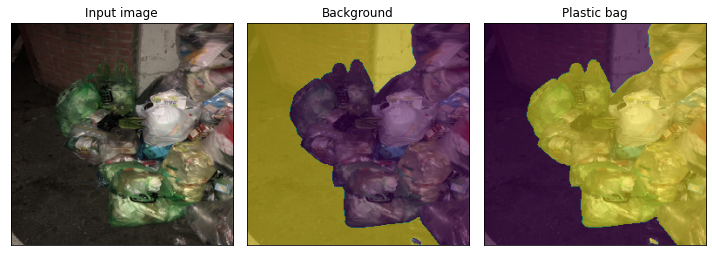

  0: Background
  1: General trash
  6: Plastic


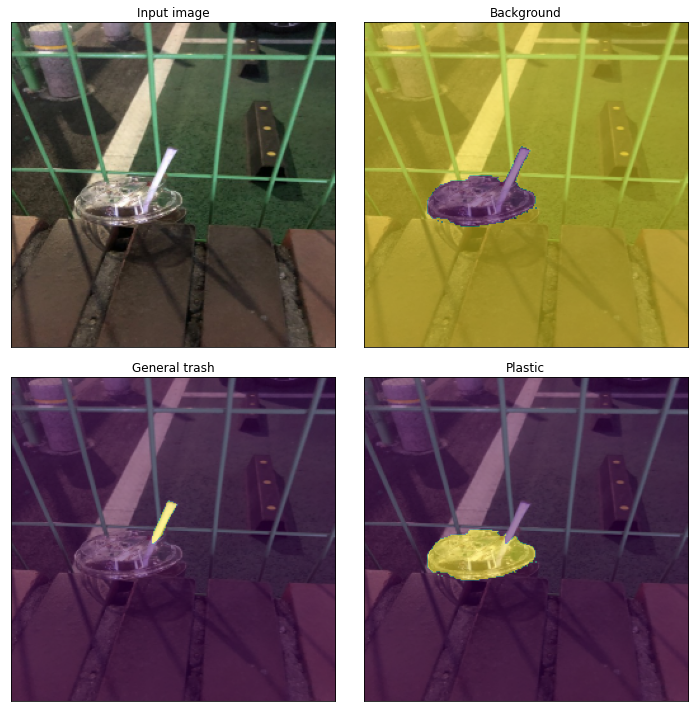

  0: Background
  8: Plastic bag


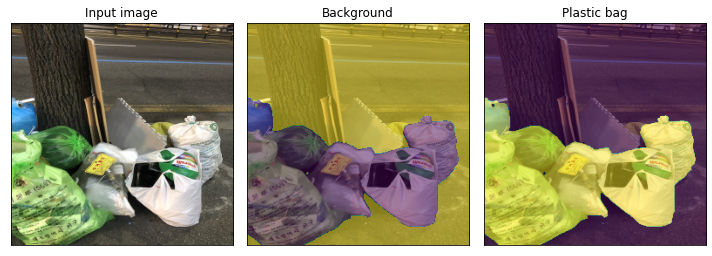

  0: Background
  2: Paper
  6: Plastic
  8: Plastic bag


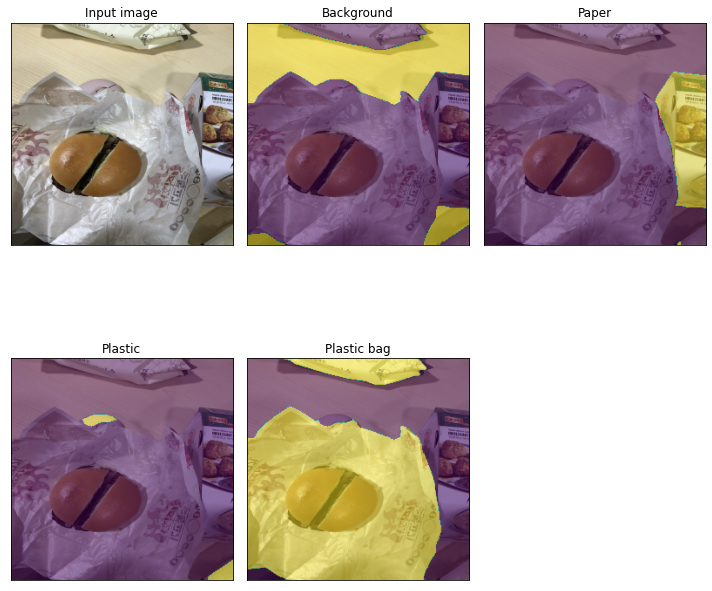

  0: Background
  2: Paper


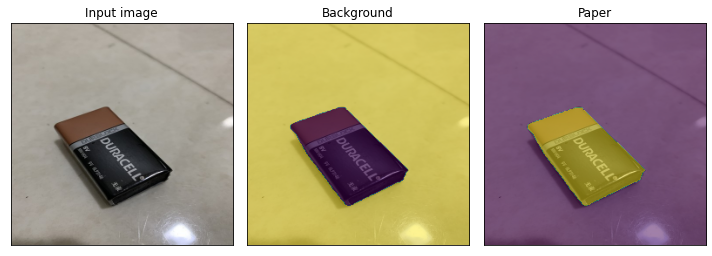

In [64]:
im_dir = "/opt/ml/segmentation/input/data/"
k = 10*0
for idx in range(k, k+10):
    
    im_name = df.image_id[idx]
    im_path = im_dir + im_name
    prediction = cls_prob[idx]
    
    image_original, labelmap = get_label_map(im_path, prediction)

    labels = np.unique(labelmap)

    # Show results
    rows = np.floor(np.sqrt(len(labels) + 1))
    cols = np.ceil((len(labels) + 1) / rows)

    plt.figure(figsize=(10, 10))
    ax = plt.subplot(rows, cols, 1)
    ax.set_title("Input image")
    ax.imshow(image_original[:, :, ::-1])
    ax.set_xticks([])
    ax.set_yticks([])
    classes = [
        'Background', 'General trash', 'Paper', 'Paper pack', 'Metal',
        'Glass', 'Plastic', 'Styrofoam', 'Plastic bag', 'Battery', 'Clothing'
    ]
    for i, label in enumerate(labels):
        print("{0:3d}: {1}".format(label, classes[label]))
        mask = labelmap == label
        ax = plt.subplot(rows, cols, i + 2)
        ax.set_title(classes[label])
        ax.imshow(image_original[..., ::-1])
        ax.imshow(mask.astype(np.float32), alpha=0.5, cmap="viridis")
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()